# Bearing Fault Diagnosis

### Load necessary packages and libraries 

In [1]:
import os
import scipy.io 
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    balanced_accuracy_score
)
import tensorflow as tf
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

### Import Data  

In [2]:
folder_path1 = os.path.join(os.getcwd(), 'CWRU_data', '2HP')
folder_path2 = os.path.join(os.getcwd(), 'CWRU_data', '3HP')

def load_cwru_data(folder_path = folder_path1):
    """
    Load CWRU bearing data from .mat files into a DataFrame.

    Args:
        folder_path (str): Path to the dataset folder.

    Returns:
        pd.DataFrame: DataFrame with columns for condition, fault size, label, and signal.
    """
    data_dict = {
        'Condition': [],
        'Fault Size (mm)': [],
        'Fault Label': [],
        'Signal': []
    }

    # Define file mappings: (file_id, condition, fault_size, fault_label)
    file_mappings_2HP = [
        ('99', 'Normal', 0, 0),
        ('124', 'RE (Rolling element)', 0.18, 1),
        ('111', 'IR (Inner ring)', 0.18, 2),
        ('137', 'OR (Outer ring)', 0.18, 3),
        ('191', 'RE (Rolling element)', 0.36, 4),
        ('176', 'IR (Inner ring)', 0.36, 5),
        ('203', 'OR (Outer ring)', 0.36, 6),
        ('228', 'RE (Rolling element)', 0.54, 7),
        ('215', 'IR (Inner ring)', 0.54, 8),
        ('240', 'OR (Outer ring)', 0.54, 9)
    ]
    # file_mappings_3HP = [
    #     ('100', 'Normal', 0, 0),
    #     ('125', 'RE (Rolling element)', 0.18, 1),
    #     ('112', 'IR (Inner ring)', 0.18, 2),
    #     ('138', 'OR (Outer ring)', 0.18, 3),
    #     ('192', 'RE (Rolling element)', 0.36, 4),
    #     ('177', 'IR (Inner ring)', 0.36, 5),
    #     ('204', 'OR (Outer ring)', 0.36, 6),
    #     ('229', 'RE (Rolling element)', 0.54, 7),
    #     ('217', 'IR (Inner ring)', 0.54, 8),
    #     ('241', 'OR (Outer ring)', 0.54, 9)
    # ]

    for file_id, condition, fault_size, fault_label in file_mappings_2HP:
    # for file_id, condition, fault_size, fault_label in file_mappings_3HP:
        file_path = os.path.join(folder_path, f'{file_id}.mat')
        if file_id == '99':
            signal = scipy.io.loadmat(file_path)[f'X0{file_id}_DE_time'].flatten()
        else:
            signal = scipy.io.loadmat(file_path)[f'X{file_id}_DE_time'].flatten()
        data_dict['Condition'].append(condition)
        data_dict['Fault Size (mm)'].append(fault_size)
        data_dict['Fault Label'].append(fault_label)
        data_dict['Signal'].append(signal)

    return pd.DataFrame(data_dict)

df = load_cwru_data(folder_path=folder_path1)


# Function to preprocess data for imbalance with different points for each label
def preprocess_data_for_imbalance(df, start_point_dict, num_points_dict):
    """
    Preprocess data by selecting a section of the signal for each fault label
    based on a given start point and number of points for each label.

    Args:
        df (pd.DataFrame): Input DataFrame containing signals and labels.
        start_point_dict (dict): Dictionary specifying the start point for each label.
        num_points_dict (dict): Dictionary specifying the number of points for each label.

    Returns:
        pd.DataFrame: Processed DataFrame with signals for each label.
    """
    processed_data = {
        'Condition': [],
        'Fault Size (mm)': [],
        'Fault Label': [],
        'Signal': []
    }

    for fault_label in df['Fault Label'].unique():
        subset = df[df['Fault Label'] == fault_label]
        if subset.empty:
            continue

        signal = subset.iloc[0]['Signal']
        condition = subset.iloc[0]['Condition']
        fault_size = subset.iloc[0]['Fault Size (mm)']

        # Get start point and number of points for the current label
        start_point = start_point_dict.get(fault_label, 0)  # Default start_point is 0
        num_points = num_points_dict.get(fault_label, len(signal))  # Default is full signal length

        # Validate range
        if start_point >= len(signal):
            print(f"Start point {start_point} is out of range for signal with length {len(signal)}. Skipping Fault Label {fault_label}.")
            continue

        end_point = min(start_point + num_points, len(signal))
        signal_section = signal[start_point:end_point]

        # Append to processed data
        processed_data['Condition'].append(condition)
        processed_data['Fault Size (mm)'].append(fault_size)
        processed_data['Fault Label'].append(fault_label)
        processed_data['Signal'].append(signal_section)

    return pd.DataFrame(processed_data)

# All classes start at index 0
start_point_dict_train = {label: 0 for label in range(10)}

# Imbalanced case: IR ratio = 50:1 for normal (class 0) vs. faults (classes 1–9)
num_points_dict_train = {0: 320000, **{label: 16000 for label in range(1, 10)}}


# Preprocess data and save to df_imbalance
df_imbalance_train = preprocess_data_for_imbalance(df, start_point_dict_train, num_points_dict_train)


# Function to preprocess data for imbalance with different points for each label

# Sampling function
def sampling(data, interval_length, samples_per_block, ignore_points=0):
    """
    Split signal data into blocks with specified intervals and block size.
    
    Args:
        data (np.array): Input signal data.
        interval_length (int): Step size for sampling.
        samples_per_block (int): Number of samples per block.
        ignore_points (int): Number of points to ignore at the start and end.
    
    Returns:
        np.array: Split data blocks.
    """
    adjusted_length = len(data) - 2 * ignore_points
    num_blocks = (
        round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1
    )
    split_data = np.zeros([num_blocks, samples_per_block])

    for i in range(num_blocks):
        start_idx = ignore_points + i * interval_length
        split_data[i, :] = data[start_idx:(start_idx + samples_per_block)].T

    return split_data


def data_preparation(data, interval_length, samples_per_block):
    """
    Prepare data by splitting and labeling for multi-class classification.
    
    Args:
        data (list): List of signal data for all classes.
        interval_length (int): Step size for sampling.
        samples_per_block (int): Number of samples per block.
    
    Returns:
        tuple: Prepared data (X), positional labels (y_positional), and class labels (y_class).
    """
    for count, signal in enumerate(data):
        split_data = sampling(signal, interval_length, samples_per_block)
        y = np.zeros([len(split_data), 10])  # One-hot encoding
        y[:, count] = 1
        y_class = np.zeros([len(split_data), 1])
        y_class[:, 0] = count

        if count == 0:
            X = split_data
            y_positional = y
            y_label = y_class
        else:
            X = np.append(X, split_data, axis=0)
            y_positional = np.append(y_positional, y, axis=0)
            y_label = np.append(y_label, y_class, axis=0)

    return X, y_positional, y_label

In [3]:
df_imbalance_train.head(10)

,Condition,Fault Size (mm),Fault Label,Signal
0,Normal,0.00,0,"[0.06425353846153846, 0.06300184615384616, -0...."
1,RE (Rolling element),0.18,1,"[0.09992676923076924, 0.14164984615384615, 0.1..."
2,IR (Inner ring),0.18,2,"[0.06133292307692308, -0.015646153846153844, -..."
3,OR (Outer ring),0.18,3,"[-0.967796, -1.7336026666666666, -2.226056, -2..."
4,RE (Rolling element),0.36,4,"[0.06446215384615385, 0.09575446153846154, 0.1..."
5,IR (Inner ring),0.36,5,"[0.16568133333333332, 0.116436, 0.0626, 0.0171..."
6,OR (Outer ring),0.36,6,"[-0.124752, -0.12913292307692306, -0.132053538..."
7,RE (Rolling element),0.54,7,"[-0.20360861538461536, -0.2953993846153846, -0..."
8,IR (Inner ring),0.54,8,"[-0.3917796923076923, -0.3844781538461538, -0...."
9,OR (Outer ring),0.54,9,"[-0.3447173333333333, -0.4323573333333333, -0...."


### Prepare dataset with overlapping windows

In [4]:
def prepare_datasets(df_imbalance, interval_length, samples_per_block):
    """
    Prepare train or test datasets using the data_preparation function.
    
    Args:
        df_imbalance (pd.DataFrame): DataFrame containing signals and labels.
        interval_length (int): Interval length for sampling.
        samples_per_block (int): Number of samples per block.
    
    Returns:
        tuple: X (input data), y_positional (one-hot labels), y_class (class labels).
    """
    signals = df_imbalance['Signal'].tolist()
    X, y_positional, y_class = data_preparation(signals, interval_length, samples_per_block)
    return X, y_positional, y_class


# Set parameters
interval_length = 320
samples_per_block = 1600


# Prepare train datasets
X, y_positional, y_class = prepare_datasets(df_imbalance_train, interval_length, samples_per_block)

In [5]:
X.shape, y_positional.shape, y_class.shape

((1390, 1600), (1390, 10), (1390, 1))

### Manual Splitting & K-Fold Cross Validation 

In [6]:
def time_series_stratified_split(X, y, train_ratio = 0.8):
    num_classes = y.shape[1]
    X_train, y_train, X_test, y_test = [], [], [], []

    for cls in range(num_classes):
        cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
        n_train = int(train_ratio * len(cls_indices))
        train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
        X_train.append(X[train_idx])
        # print("X_train shape:", len(X_train))
        y_train.append(y[train_idx])
        # print("y_train shape:", len(X_train))
        X_test.append(X[test_idx])
        # print("X_train shape:", len(X_train))
        y_test.append(y[test_idx])
        # print("y_test shape:", len(X_train))

    return (
        np.concatenate(X_train),
        np.concatenate(y_train),
        np.concatenate(X_test),
        np.concatenate(y_test)
    )

In [7]:
foldername_cnn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_20_1_Ratio", "1D_CNN")
foldername_cnn_attn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_20_1_Ratio", "1D_CNN_Attention")

foldername_cnn_lstm = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_20_1_Ratio", "1D_CNN_LSTM")
foldername_cnn_lstm_attn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_20_1_Ratio", "1D_CNN_LSTM_Attention")

os.makedirs(foldername_cnn, exist_ok=True)
os.makedirs(foldername_cnn_attn, exist_ok=True)
os.makedirs(foldername_cnn_lstm, exist_ok=True)
os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

In [8]:
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

X_1D_train = X_train.reshape([-1, samples_per_block, 1])
X_1D_test = X_test.reshape([-1, samples_per_block, 1])

input_shape = (samples_per_block, 1)
y_train_classes = np.argmax(y_train, axis=1)

X_1D_train.shape, y_train_classes.shape, X_1D_test.shape, y_test.shape, input_shape

((1110, 1600, 1), (1110,), (280, 1600, 1), (280, 10), (1600, 1))

In [9]:
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

## NEURAL NETWORK MODELS

### 1D CNN Model

In [10]:
class CNN_1D():
    def __init__(self):
        self.model = self.CreateModel()
        self.model.summary()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            
            layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(10, activation='softmax')
        ])

        # Optimizer with a slightly higher learning rate
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.summary()
        return model


os.makedirs(foldername_cnn, exist_ok=True)


# Metric storage
accuracy_1D_cnn, precision_1D_cnn, recall_1D_cnn, f1_1D_cnn, log_loss_1D_cnn, balanced_accuracy_1D_cnn = [], [], [], [], [], []
accuracy_1D_test_cnn, precision_1D_test_cnn, recall_1D_test_cnn, f1_1D_test_cnn, log_loss_1D_test_cnn, balanced_accuracy_1D_test_cnn = [], [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn, f"best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D()
    model.model.fit(
        X_1D_train[train_idx], y_train[train_idx],
        validation_data=(X_1D_train[val_idx], y_train[val_idx]),
        epochs=20,
        verbose=1,
        callbacks=[checkpoint]
    )

    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()


    print(f"Best model saved at: {checkpoint_filepath}")



Fold 1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2905 - loss: 2.0448
Epoch 1: val_accuracy improved from -inf to 0.74775, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3074 - loss: 2.0101 - val_accuracy: 0.7477 - val_loss: 1.9220
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8196 - loss: 0.6182
Epoch 2: val_accuracy did not improve from 0.74775
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8188 - loss: 0.6180 - val_accuracy: 0.7342 - val_loss: 1.5846
Epoch 3/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8364 - loss: 0.5197
Epoch 3: val_accuracy did not improve from 0.74775
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8368 - loss: 0.5177 - val_accuracy: 0.7162 - val_loss: 1.4215
Epoch 4/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8561 - loss: 0.4222
Epoch 4: val_accuracy did not impro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_1.keras

Fold 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6181 - loss: 1.5534
Epoch 1: val_accuracy improved from -inf to 0.75676, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_2.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6251 - loss: 1.5189 - val_accuracy: 0.7568 - val_loss: 2.1038
Epoch 2/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7848 - loss: 0.5700
Epoch 2: val_accuracy did not improve from 0.75676
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7859 - loss: 0.5677 - val_accuracy: 0.7568 - val_loss: 2.1183
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8437 - loss: 0.4544
Epoch 3: val_accuracy did not improve from 0.75676
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8437 - loss: 0.4546 - val_accuracy: 0.0360 - val_loss: 2.2219
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8601 - loss: 0.3921
Epoch 4: val_accuracy did not impro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_2.keras

Fold 3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3646 - loss: 2.0532
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3890 - loss: 2.0060 - val_accuracy: 0.7162 - val_loss: 2.0028
Epoch 2/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8049 - loss: 0.7118
Epoch 2: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8050 - loss: 0.7056 - val_accuracy: 0.7162 - val_loss: 1.6908
Epoch 3/20
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8482 - loss: 0.4577
Epoch 3: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8481 - loss: 0.4564 - val_accuracy: 0.7162 - val_loss: 1.6668
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8689 - loss: 0.3749
Epoch 4: val_accuracy did not impro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_3.keras

Fold 4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4990 - loss: 1.8020
Epoch 1: val_accuracy improved from -inf to 0.74775, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_4.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5108 - loss: 1.7692 - val_accuracy: 0.7477 - val_loss: 2.0870
Epoch 2/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7753 - loss: 0.7006
Epoch 2: val_accuracy did not improve from 0.74775
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7768 - loss: 0.6956 - val_accuracy: 0.7252 - val_loss: 2.0157
Epoch 3/20
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8186 - loss: 0.5029
Epoch 3: val_accuracy did not improve from 0.74775
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8209 - loss: 0.4995 - val_accuracy: 0.0315 - val_loss: 2.1807
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8494 - loss: 0.4052
Epoch 4: val_accuracy did not impro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5572 - loss: 1.5955
Epoch 1: val_accuracy improved from -inf to 0.74775, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_5.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5720 - loss: 1.5459 - val_accuracy: 0.7477 - val_loss: 2.0526
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8265 - loss: 0.5244
Epoch 2: val_accuracy did not improve from 0.74775
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8262 - loss: 0.5249 - val_accuracy: 0.7207 - val_loss: 2.0432
Epoch 3/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8347 - loss: 0.4804
Epoch 3: val_accuracy did not improve from 0.74775
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8353 - loss: 0.4790 - val_accuracy: 0.0315 - val_loss: 2.2147
Epoch 4/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8585 - loss: 0.4037
Epoch 4: val_accuracy did not impro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN/best_model_5.keras


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
print("1D CNN Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn}")
print(f"Precision: {precision_1D_test_cnn}")
print(f"Recall: {recall_1D_test_cnn}")
print(f"F1 Score: {f1_1D_test_cnn}")
print(f"Log Loss: {log_loss_1D_test_cnn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn}")

1D CNN Metrics:
Train Accuracy: [0.793, 0.758, 0.847, 0.894, 0.748]
Test Accuracy: [0.786, 0.754, 0.832, 0.904, 0.743]
Precision: [0.763, 0.593, 0.82, 0.911, 0.574]
Recall: [0.786, 0.754, 0.832, 0.904, 0.743]
F1 Score: [0.756, 0.662, 0.815, 0.891, 0.648]
Log Loss: [0.742, 2.105, 0.991, 0.586, 2.054]
Balanced Accuracy: [0.333, 0.233, 0.478, 0.7, 0.2]


### 1D CNN + Attention Model

In [12]:
from keras import layers, models, Input
from keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense, GlobalAveragePooling1D, Conv1D, MaxPooling1D, BatchNormalization

class CNN_1D_Attn():
    def __init__(self, input_shape):
        self.model = self.CreateModel(input_shape)
        self.model.summary()

    def CreateModel(self, input_shape):
        inputs = Input(shape=input_shape)

        x = Conv1D(16, 3, strides=1, padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)

        x = Conv1D(32, 3, strides=1, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)  # Shape: (seq_len, 64)

        # Attention Layer
        x_norm = LayerNormalization()(x)
        attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(x_norm, x_norm)
        x = layers.Add()([x, attn_output])  # Residual Connection
        x = LayerNormalization()(x)

        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(10, activation='softmax')(x)

        model = models.Model(inputs, output)

        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        model.summary()
        return model
    
os.makedirs(foldername_cnn_attn, exist_ok=True)

# Split the data
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

# Reshape for CNN input
X_1D_train = X_train.reshape([-1, samples_per_block, 1])
X_1D_test = X_test.reshape([-1, samples_per_block, 1])
input_shape = (samples_per_block, 1)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
accuracy_1D_cnn_attn, precision_1D_cnn_attn, recall_1D_cnn_attn, f1_1D_cnn_attn, log_loss_1D_cnn_attn, balanced_accuracy_1D_cnn_attn = [], [], [], [], [], []
accuracy_1D_test_cnn_attn, precision_1D_test_cnn_attn, recall_1D_test_cnn_attn, f1_1D_test_cnn_attn, log_loss_1D_test_cnn_attn, balanced_accuracy_1D_test_cnn_attn = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_Attn(input_shape=(1600, 1))
    model.model.fit(
        X_1D_train[train_idx], y_train[train_idx],
        validation_data=(X_1D_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_attn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_attn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_attn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_attn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_attn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_attn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_attn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_attn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_attn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_attn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_attn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_attn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 64)   │        128 │ max_pooling1d_17… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 64)   │          0 │ max_pooling1d_17… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │        650 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 64)   │        128 │ max_pooling1d_17… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 64)   │          0 │ max_pooling1d_17… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │        650 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5365 - loss: 1.4735
Epoch 1: val_accuracy improved from -inf to 0.72072, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.5420 - loss: 1.4561 - val_accuracy: 0.7207 - val_loss: 1.3238
Epoch 2/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8001 - loss: 0.5550
Epoch 2: val_accuracy improved from 0.72072 to 0.72973, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8008 - loss: 0.5510 - val_accuracy: 0.7297 - val_loss: 0.9799
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8641 - loss: 0.4092
Epoch 3: val_accuracy did not improve from 0.72973
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_20… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_20… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │        650 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_20… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_20… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │        650 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5385 - loss: 1.5395
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_2.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.5440 - loss: 1.5231 - val_accuracy: 0.7162 - val_loss: 1.5370
Epoch 2/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7804 - loss: 0.6048
Epoch 2: val_accuracy improved from 0.71622 to 0.76577, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_2.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7827 - loss: 0.5986 - val_accuracy: 0.7658 - val_loss: 0.9815
Epoch 3/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8345 - loss: 0.4459
Epoch 3: val_accuracy did not improve from 0.76577
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_23… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_23… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10)        │        650 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_23… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_23… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10)        │        650 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4699 - loss: 1.6617
Epoch 1: val_accuracy improved from -inf to 0.75676, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4828 - loss: 1.6236 - val_accuracy: 0.7568 - val_loss: 0.8767
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7911 - loss: 0.5775
Epoch 2: val_accuracy did not improve from 0.75676
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7909 - loss: 0.5772 - val_accuracy: 0.0811 - val_loss: 1.8940
Epoch 3/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8279 - loss: 0.5281
Epoch 3: val_accuracy did not improve from 0.75676
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8287 - loss: 0.5239 - val_accuracy: 0.0766 - val_loss: 4.1533
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8687 - loss: 0.3820
Epoch 4:

Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_26… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_26… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 10)        │        650 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_26… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_26… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 10)        │        650 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6505 - loss: 1.1267
Epoch 1: val_accuracy improved from -inf to 0.72072, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_4.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6540 - loss: 1.1162 - val_accuracy: 0.7207 - val_loss: 1.4094
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8017 - loss: 0.5752
Epoch 2: val_accuracy did not improve from 0.72072
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8025 - loss: 0.5731 - val_accuracy: 0.0315 - val_loss: 2.9217
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8549 - loss: 0.4263
Epoch 3: val_accuracy did not improve from 0.72072
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8549 - loss: 0.4267 - val_accuracy: 0.0315 - val_loss: 5.0833
Epoch 4/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8389 - loss: 0.4017
Epoch 4:

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_28… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_29… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_29… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 10)        │        650 │ dropout_18[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_28… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_29… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_29… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 10)        │        650 │ dropout_18[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4923 - loss: 1.5297
Epoch 1: val_accuracy improved from -inf to 0.74775, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_5.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4986 - loss: 1.5130 - val_accuracy: 0.7477 - val_loss: 1.4401
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8059 - loss: 0.5752
Epoch 2: val_accuracy improved from 0.74775 to 0.77928, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_5.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8065 - loss: 0.5739 - val_accuracy: 0.7793 - val_loss: 0.8281
Epoch 3/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8249 - loss: 0.4813
Epoch 3: val_accuracy did not improve from 0.77928
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8

In [13]:
print("1D CNN+Attention Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_attn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_attn}")
print(f"Precision: {precision_1D_test_cnn_attn}")
print(f"Recall: {recall_1D_test_cnn_attn}")
print(f"F1 Score: {f1_1D_test_cnn_attn}")
print(f"Log Loss: {log_loss_1D_test_cnn_attn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_attn}")

1D CNN+Attention Metrics:
Train Accuracy: [0.998, 1.0, 0.999, 0.997, 1.0]
Test Accuracy: [0.936, 0.979, 0.961, 0.957, 0.993]
Precision: [0.945, 0.985, 0.975, 0.962, 0.994]
Recall: [0.936, 0.979, 0.961, 0.957, 0.993]
F1 Score: [0.934, 0.977, 0.953, 0.956, 0.993]
Log Loss: [0.18, 0.063, 0.097, 0.081, 0.03]
Balanced Accuracy: [0.8, 0.933, 0.878, 0.867, 0.978]


### 1D CNN + LSTM Model

In [14]:
class CNN_LSTM_1D():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        from keras.layers import Reshape, multiply, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
        from keras.models import Model

        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        ec1_layer1 = Conv1D(50, 20, strides=2, activation='relu')(X)
        ec1_layer2 = Conv1D(30, 10, strides=2, activation='relu')(ec1_layer1)
        ec1_outputs = MaxPooling1D(pool_size=2)(ec1_layer2)

        ec2_layer1 = Conv1D(50, 8, strides=2, activation='relu')(X)
        ec2_layer2 = Conv1D(40, 6, strides=2, activation='relu')(ec2_layer1)
        ec2_layer3 = MaxPooling1D(pool_size=2)(ec2_layer2)
        ec2_layer4 = Conv1D(30, 4, strides=1, activation='relu')(ec2_layer3)
        ec2_outputs = ec2_layer4

        encoder = multiply([ec1_outputs, ec2_outputs])

        x = LSTM(60, return_sequences=True)(encoder)
        x = LSTM(60)(x)
        x = Dropout(0.5)(x)
        output = Dense(10, activation='softmax')(x)

        model = Model(input_seq, output)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

# Create directory for CNN + LSTM results
os.makedirs(foldername_cnn_lstm, exist_ok=True)

# Split the data
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

y_train_classes = np.argmax(y_train, axis=1)

# Metric storage
accuracy_1D_cnn_lstm, precision_1D_cnn_lstm, recall_1D_cnn_lstm, f1_1D_cnn_lstm, log_loss_1D_cnn_lstm, balanced_accuracy_1D_cnn_lstm = [], [], [], [], [], []
accuracy_1D_test_cnn_lstm, precision_1D_test_cnn_lstm, recall_1D_test_cnn_lstm, f1_1D_test_cnn_lstm, log_loss_1D_test_cnn_lstm, balanced_accuracy_1D_test_cnn_lstm = [], [], [], [], [], []

# ------------------ Training Loop ------------------
# for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_LSTM_1D()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=20,
        verbose=1,
        callbacks=[checkpoint]
    )

    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_lstm.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_lstm.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_lstm.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_lstm.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_lstm.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_lstm.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + LSTM Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_lstm.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_lstm.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_lstm.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_lstm.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_lstm.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_lstm.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + LSTM Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")





Fold 1


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1600, 1)   │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 198, 40)   │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 195, 30)   │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 195, 30)   │          0 │ max_pooling1d_30… │
│                     │                   │            │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 195, 60)   │     21,840 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60)        │     29,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 60)        │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 10)        │        610 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1600, 1)   │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 198, 40)   │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 195, 30)   │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 195, 30)   │          0 │ max_pooling1d_30… │
│                     │                   │            │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 195, 60)   │     21,840 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60)        │     29,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 60)        │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 10)        │        610 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6310 - loss: 2.0240
Epoch 1: val_accuracy improved from -inf to 0.74324, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6334 - loss: 2.0109 - val_accuracy: 0.7432 - val_loss: 0.9727
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7791 - loss: 0.7340
Epoch 2: val_accuracy improved from 0.74324 to 0.75676, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7784 - loss: 0.7333 - val_accuracy: 0.7568 - val_loss: 0.6075
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7862 - loss: 0.5915
Epoch 3: val_accuracy improved from 0.75676 to 0.78829, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_F

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_1.keras

Fold 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 198, 40)   │          0 │ conv1d_38[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 195, 30)   │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_33… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 195, 30)   │          0 │ max_pooling1d_32… │
│ (Multiply)          │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60)        │     29,040 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 60)        │          0 │ lstm_3[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 10)        │        610 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 198, 40)   │          0 │ conv1d_38[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 195, 30)   │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_33… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 195, 30)   │          0 │ max_pooling1d_32… │
│ (Multiply)          │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60)        │     29,040 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 60)        │          0 │ lstm_3[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 10)        │        610 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6329 - loss: 2.0490
Epoch 1: val_accuracy improved from -inf to 0.73423, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_2.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6351 - loss: 2.0370 - val_accuracy: 0.7342 - val_loss: 0.9050
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7755 - loss: 0.7640
Epoch 2: val_accuracy improved from 0.73423 to 0.75225, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_2.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7750 - loss: 0.7654 - val_accuracy: 0.7523 - val_loss: 0.8271
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7688 - loss: 0.7457
Epoch 3: val_accuracy improved from 0.75225 to 0.77477, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_F

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_2.keras

Fold 3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 198, 40)   │          0 │ conv1d_43[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 195, 30)   │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_35… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 195, 30)   │          0 │ max_pooling1d_34… │
│ (Multiply)          │                   │            │ conv1d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60)        │     29,040 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 60)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 10)        │        610 │ dropout_22[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 198, 40)   │          0 │ conv1d_43[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 195, 30)   │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_35… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 195, 30)   │          0 │ max_pooling1d_34… │
│ (Multiply)          │                   │            │ conv1d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60)        │     29,040 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 60)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 10)        │        610 │ dropout_22[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6027 - loss: 2.0179
Epoch 1: val_accuracy improved from -inf to 0.75676, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.6058 - loss: 2.0054 - val_accuracy: 0.7568 - val_loss: 1.0561
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7143 - loss: 0.9765
Epoch 2: val_accuracy did not improve from 0.75676
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7149 - loss: 0.9741 - val_accuracy: 0.7523 - val_loss: 1.0639
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7431 - loss: 1.1591
Epoch 3: val_accuracy improved from 0.75676 to 0.76577, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.7433 - loss: 1.1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_3.keras

Fold 4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 198, 40)   │          0 │ conv1d_48[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 195, 30)   │          0 │ conv1d_46[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_37… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 195, 30)   │          0 │ max_pooling1d_36… │
│ (Multiply)          │                   │            │ conv1d_49[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60)        │     29,040 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 60)        │          0 │ lstm_7[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 10)        │        610 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 198, 40)   │          0 │ conv1d_48[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 195, 30)   │          0 │ conv1d_46[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_37… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 195, 30)   │          0 │ max_pooling1d_36… │
│ (Multiply)          │                   │            │ conv1d_49[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60)        │     29,040 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 60)        │          0 │ lstm_7[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 10)        │        610 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6568 - loss: 2.0100
Epoch 1: val_accuracy improved from -inf to 0.74775, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_4.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.6583 - loss: 1.9997 - val_accuracy: 0.7477 - val_loss: 1.0210
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7544 - loss: 0.9046
Epoch 2: val_accuracy improved from 0.74775 to 0.78378, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_4.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7548 - loss: 0.9014 - val_accuracy: 0.7838 - val_loss: 0.7922
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7585 - loss: 0.7316
Epoch 3: val_accuracy did not improve from 0.78378
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7588 - loss: 0.7320 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 198, 40)   │          0 │ conv1d_53[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 195, 30)   │          0 │ conv1d_51[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_39… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 195, 30)   │          0 │ max_pooling1d_38… │
│ (Multiply)          │                   │            │ conv1d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 60)        │     29,040 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 60)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 10)        │        610 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 198, 40)   │          0 │ conv1d_53[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 195, 30)   │          0 │ conv1d_51[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_39… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 195, 30)   │          0 │ max_pooling1d_38… │
│ (Multiply)          │                   │            │ conv1d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 60)        │     29,040 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 60)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 10)        │        610 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6419 - loss: 2.0170
Epoch 1: val_accuracy improved from -inf to 0.77027, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_5.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.6440 - loss: 2.0027 - val_accuracy: 0.7703 - val_loss: 0.6576
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7444 - loss: 0.8174
Epoch 2: val_accuracy did not improve from 0.77027
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7450 - loss: 0.8175 - val_accuracy: 0.7703 - val_loss: 0.7322
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7758 - loss: 0.7670
Epoch 3: val_accuracy improved from 0.77027 to 0.77477, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_5.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7760 - loss: 0.7

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_5.keras


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
print("1D CNN+LSTM Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_lstm}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_lstm}")
print(f"Precision: {precision_1D_test_cnn_lstm}")
print(f"Recall: {recall_1D_test_cnn_lstm}")
print(f"F1 Score: {f1_1D_test_cnn_lstm}")
print(f"Log Loss: {log_loss_1D_test_cnn_lstm}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_lstm}")


1D CNN+LSTM Metrics:
Train Accuracy: [0.856, 0.867, 0.839, 0.873, 0.831]
Test Accuracy: [0.85, 0.868, 0.818, 0.854, 0.829]
Precision: [0.811, 0.812, 0.776, 0.835, 0.758]
Recall: [0.85, 0.868, 0.818, 0.854, 0.829]
F1 Score: [0.812, 0.83, 0.79, 0.825, 0.777]
Log Loss: [0.441, 0.433, 0.467, 0.44, 0.607]
Balanced Accuracy: [0.533, 0.589, 0.433, 0.544, 0.467]


### 1D CNN + LSTM + ATTENTION

In [16]:
## Model 2
from keras import layers, Model, Input
from keras.layers import (
    Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional,
    BatchNormalization, LayerNormalization, MultiHeadAttention,
    Reshape, Concatenate, Add, Activation
)
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

class CNN_1D_LSTM_Attention():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        # CNN Branch 1
        branch1 = Conv1D(32, 10, strides=2, padding='same')(X)  # (800, 32)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = Conv1D(16, 5, strides=2, padding='same')(branch1)  # (400, 16)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = MaxPooling1D(pool_size=2)(branch1)  # (200, 16)

        # Residual shortcut
        shortcut1 = Conv1D(16, 1, strides=4, padding='same')(X)  # (400, 16)
        shortcut1 = MaxPooling1D(pool_size=2)(shortcut1)  # (200, 16)
        branch1 = Add()([branch1, shortcut1])  # (200, 16)

        # CNN Branch 2
        branch2 = Conv1D(32, 6, strides=2, padding='same')(X)  # (800, 32)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = Conv1D(16, 3, strides=2, padding='same')(branch2)  # (400, 16)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = MaxPooling1D(pool_size=2)(branch2)  # (200, 16)

        # Merge branches
        combined = Concatenate(axis=-1)([branch1, branch2])  # (200, 32)
        combined = LayerNormalization()(combined)

        # Multi-head attention
        attn_out = MultiHeadAttention(num_heads=4, key_dim=8)(combined, combined)
        attn_out = LayerNormalization()(attn_out)

        # Bidirectional LSTM
        x = Bidirectional(LSTM(32, return_sequences=True))(attn_out)
        x = Bidirectional(LSTM(32))(x)

        # Fully connected layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(10, activation='softmax', kernel_regularizer=l2(0.01))(x)

        # Final model
        model = Model(input_seq, output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()

        # Learning rate scheduler
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        self.callbacks = [lr_scheduler]

        return model

os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
accuracy_1D_cnn_lstm_attn, precision_1D_cnn_lstm_attn, recall_1D_cnn_lstm_attn, f1_1D_cnn_lstm_attn, log_loss_1D_cnn_lstm_attn, balanced_accuracy_1D_cnn_lstm_attn = [], [], [], [], [], []
accuracy_1D_test_cnn_lstm_attn, precision_1D_test_cnn_lstm_attn, recall_1D_test_cnn_lstm_attn, f1_1D_test_cnn_lstm_attn, log_loss_1D_test_cnn_lstm_attn, balanced_accuracy_1D_test_cnn_lstm_attn = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_LSTM_Attention()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_lstm_attn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_lstm_attn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_lstm_attn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_lstm_attn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_lstm_attn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_lstm_attn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + LSTM + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_lstm_attn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_lstm_attn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_lstm_attn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_lstm_attn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_lstm_attn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_lstm_attn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + LSTM + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 200, 16)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 200, 16)   │          0 │ conv1d_57[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_40… │
│                     │                   │            │ max_pooling1d_41… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_42    │ (None, 200, 16)   │          0 │ activation_3[0][

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 200, 16)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 200, 16)   │          0 │ conv1d_57[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_40… │
│                     │                   │            │ max_pooling1d_41… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_42    │ (None, 200, 16)   │          0 │ activation_3[0][

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5496 - loss: 2.1729
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.5539 - loss: 2.1682 - val_accuracy: 0.7162 - val_loss: 2.1812
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7381 - loss: 1.7167
Epoch 2: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7388 - loss: 1.7131 - val_accuracy: 0.7162 - val_loss: 1.8189
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7662 - loss: 1.3719
Epoch 3: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7664 - loss: 1.3690 - val_accuracy: 0.7162 - val_loss: 1.5398
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7627 - loss

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_1.keras

Fold 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_43    │ (None, 200, 16)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 200, 16)   │          0 │ conv1d_62[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_43… │
│                     │                   │            │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 200, 16)   │          0 │ activation_7[0][

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_43    │ (None, 200, 16)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 200, 16)   │          0 │ conv1d_62[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_43… │
│                     │                   │            │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 200, 16)   │          0 │ activation_7[0][

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2832 - loss: 2.2573
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_2.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.2898 - loss: 2.2527 - val_accuracy: 0.7162 - val_loss: 2.0399
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7188 - loss: 1.7737
Epoch 2: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7191 - loss: 1.7706 - val_accuracy: 0.7162 - val_loss: 1.6416
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7543 - loss: 1.4004
Epoch 3: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7545 - loss: 1.3979 - val_accuracy: 0.7162 - val_loss: 1.3666
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7389 - loss

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_65[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_46    │ (None, 200, 16)   │          0 │ activation_9[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_47    │ (None, 200, 16)   │          0 │ conv1d_67[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_46… │
│                     │                   │            │ max_pooling1d_47… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_48    │ (None, 200, 16)   │          0 │ activation_11[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_65[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_46    │ (None, 200, 16)   │          0 │ activation_9[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_47    │ (None, 200, 16)   │          0 │ conv1d_67[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_46… │
│                     │                   │            │ max_pooling1d_47… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_48    │ (None, 200, 16)   │          0 │ activation_11[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2491 - loss: 2.4389
Epoch 1: val_accuracy improved from -inf to 0.74324, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.2558 - loss: 2.4337 - val_accuracy: 0.7432 - val_loss: 2.2052
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7588 - loss: 1.8549
Epoch 2: val_accuracy did not improve from 0.74324
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7587 - loss: 1.8515 - val_accuracy: 0.7162 - val_loss: 1.8757
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7517 - loss: 1.4495
Epoch 3: val_accuracy did not improve from 0.74324
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7520 - loss: 1.4471 - val_accuracy: 0.7162 - val_loss: 1.6146
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7681 - loss: 

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 200, 16)   │          0 │ activation_13[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_50    │ (None, 200, 16)   │          0 │ conv1d_72[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_49… │
│                     │                   │            │ max_pooling1d_50… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_51    │ (None, 200, 16)   │          0 │ activation_15[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 200, 16)   │          0 │ activation_13[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_50    │ (None, 200, 16)   │          0 │ conv1d_72[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_49… │
│                     │                   │            │ max_pooling1d_50… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_51    │ (None, 200, 16)   │          0 │ activation_15[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2904 - loss: 2.3244
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_4.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.2984 - loss: 2.3181 - val_accuracy: 0.7162 - val_loss: 2.0421
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7574 - loss: 1.6951
Epoch 2: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7573 - loss: 1.6916 - val_accuracy: 0.7162 - val_loss: 1.6751
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7716 - loss: 1.3170
Epoch 3: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7717 - loss: 1.3145 - val_accuracy: 0.7162 - val_loss: 1.4265
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8137 - loss:

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_75[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_76[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 200, 16)   │          0 │ activation_17[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 200, 16)   │          0 │ conv1d_77[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_52… │
│                     │                   │            │ max_pooling1d_53… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_54    │ (None, 200, 16)   │          0 │ activation_19[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_75[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_76[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 200, 16)   │          0 │ activation_17[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 200, 16)   │          0 │ conv1d_77[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_52… │
│                     │                   │            │ max_pooling1d_53… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_54    │ (None, 200, 16)   │          0 │ activation_19[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.5427 - loss: 2.1910 
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_5.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1047s 39s/step - accuracy: 0.5461 - loss: 2.1858 - val_accuracy: 0.7162 - val_loss: 2.1139
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7542 - loss: 1.6726
Epoch 2: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7539 - loss: 1.6704 - val_accuracy: 0.7162 - val_loss: 1.9427
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.7518 - loss: 1.3414 
Epoch 3: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 1025s 38s/step - accuracy: 0.7523 - loss: 1.3388 - val_accuracy: 0.7162 - val_loss: 1.8277
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.7768 - loss: 

In [17]:
print("1D CNN+LSTM+ATTENTION Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_lstm_attn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_lstm_attn}")
print(f"Precision: {precision_1D_test_cnn_lstm_attn}")
print(f"Recall: {recall_1D_test_cnn_lstm_attn}")
print(f"F1 Score: {f1_1D_test_cnn_lstm_attn}")
print(f"Log Loss: {log_loss_1D_test_cnn_lstm_attn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_lstm_attn}")

1D CNN+LSTM+ATTENTION Metrics:
Train Accuracy: [0.946, 0.986, 0.995, 0.986, 0.979]
Test Accuracy: [0.914, 0.982, 0.964, 0.979, 0.986]
Precision: [0.892, 0.984, 0.968, 0.981, 0.987]
Recall: [0.914, 0.982, 0.964, 0.979, 0.986]
F1 Score: [0.897, 0.982, 0.963, 0.978, 0.985]
Log Loss: [0.25, 0.17, 0.172, 0.137, 0.163]
Balanced Accuracy: [0.733, 0.944, 0.889, 0.933, 0.956]


### Modified Model

In [18]:
## Model 2
from keras import layers, Model, Input
from keras.layers import (
    Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional,
    BatchNormalization, LayerNormalization, MultiHeadAttention,
    Reshape, Concatenate, Add, Activation
)
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

class CNN_1D_LSTM_Attn_Modified():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        # CNN Branch 1
        branch1 = Conv1D(64, 10, strides=2, padding='same')(X)  # (800, 32)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = Conv1D(64, 5, strides=2, padding='same')(branch1)  # (400, 16)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = MaxPooling1D(pool_size=2)(branch1)  # (200, 16)

        # Residual shortcut
        shortcut1 = Conv1D(64, 1, strides=4, padding='same')(X)  # (400, 16)
        shortcut1 = MaxPooling1D(pool_size=2)(shortcut1)  # (200, 16)
        branch1 = Add()([branch1, shortcut1])  # (200, 16)

        # CNN Branch 2
        branch2 = Conv1D(64, 6, strides=2, padding='same')(X)  # (800, 32)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = Conv1D(32, 3, strides=2, padding='same')(branch2)  # (400, 16)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = MaxPooling1D(pool_size=2)(branch2)  # (200, 16)

        # Merge branches
        combined = Concatenate(axis=-1)([branch1, branch2])  # (200, 32)
        combined = LayerNormalization()(combined)

        # Multi-head attention
        attn_out = MultiHeadAttention(num_heads=4, key_dim=8)(combined, combined)
        attn_out = LayerNormalization()(attn_out)

        # Bidirectional LSTM
        x = Bidirectional(LSTM(32, return_sequences=True))(attn_out)
        x = Bidirectional(LSTM(32))(x)

        # Fully connected layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(10, activation='softmax', kernel_regularizer=l2(0.01))(x)

        # Final model
        model = Model(input_seq, output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()

        # # Learning rate scheduler
        # lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        # self.callbacks = [lr_scheduler]

        return model

os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
mod_accuracy_1D, mod_precision_1D, mod_recall_1D, mod_f1_1D, mod_log_loss_1D, mod_balanced_accuracy_1D = [], [], [], [], [], []
mod_accuracy_1D_test, mod_precision_1D_test, mod_recall_1D_test, mod_f1_1D_test, mod_log_loss_1D_test, mod_balanced_accuracy_1D_test = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm_attn, f"modified_1D_CNN_LSTM_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_LSTM_Attn_Modified()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    mod_accuracy_1D.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    mod_precision_1D.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_recall_1D.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_f1_1D.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_log_loss_1D.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    mod_balanced_accuracy_1D.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Modified_1D CNN + LSTM + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"Modified_1D_CNN_LSTM_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    mod_accuracy_1D_test.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    mod_precision_1D_test.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_recall_1D_test.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_f1_1D_test.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_log_loss_1D_test.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    mod_balanced_accuracy_1D_test.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'Modified_1D CNN + LSTM + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"Modified_1D_CNN_LSTM_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1600, 1)   │          0 │ input_layer_20[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_80[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_83 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_84[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 200, 64)   │          0 │ activation_21[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 200, 64)   │          0 │ conv1d_82[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_55… │
│                     │                   │            │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1600, 1)   │          0 │ input_layer_20[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_80[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_83 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_84[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 200, 64)   │          0 │ activation_21[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 200, 64)   │          0 │ conv1d_82[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_55… │
│                     │                   │            │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.2683 - loss: 2.4141 
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1080s 40s/step - accuracy: 0.2761 - loss: 2.4081 - val_accuracy: 0.7162 - val_loss: 2.1224
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.7161 - loss: 1.8772 
Epoch 2: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 621s 23s/step - accuracy: 0.7173 - loss: 1.8733 - val_accuracy: 0.7162 - val_loss: 1.8202
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7918 - loss: 1.4622
Epoch 3: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.7917 - loss: 1.4603 - val_accuracy: 0.7162 - val_loss: 1.5509
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.790

Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 1600, 1)   │          0 │ input_layer_21[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_85[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_88[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_86[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_89[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 200, 64)   │          0 │ activation_25[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 200, 64)   │          0 │ conv1d_87[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_58… │
│                     │                   │            │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 1600, 1)   │          0 │ input_layer_21[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_85[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_88[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_86[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_89[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 200, 64)   │          0 │ activation_25[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 200, 64)   │          0 │ conv1d_87[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_58… │
│                     │                   │            │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2397 - loss: 2.3944
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_2.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.2470 - loss: 2.3893 - val_accuracy: 0.7162 - val_loss: 2.0883
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7264 - loss: 1.9464
Epoch 2: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.7274 - loss: 1.9438 - val_accuracy: 0.7162 - val_loss: 1.8442
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7768 - loss: 1.5786
Epoch 3: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.7769 - loss: 1.5769 - val_accuracy: 0.7162 - val_loss: 1.5879
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.81

Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1600, 1)   │          0 │ input_layer_22[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_90 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_90[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_93[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_91[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_94[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 200, 64)   │          0 │ activation_29[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_62    │ (None, 200, 64)   │          0 │ conv1d_92[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_61… │
│                     │                   │            │ max_pooling1d_62… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1600, 1)   │          0 │ input_layer_22[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_90 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_90[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_93[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_91[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_94[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 200, 64)   │          0 │ activation_29[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_62    │ (None, 200, 64)   │          0 │ conv1d_92[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_61… │
│                     │                   │            │ max_pooling1d_62… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3721 - loss: 2.2479
Epoch 1: val_accuracy improved from -inf to 0.76577, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.3781 - loss: 2.2434 - val_accuracy: 0.7658 - val_loss: 2.2351
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7827 - loss: 1.7780
Epoch 2: val_accuracy did not improve from 0.76577
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7828 - loss: 1.7750 - val_accuracy: 0.7162 - val_loss: 2.0909
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7848 - loss: 1.4301
Epoch 3: val_accuracy did not improve from 0.76577
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7854 - loss: 1.4274 - val_accuracy: 0.7162 - val_loss: 1.8828
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.81

Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1600, 1)   │          0 │ input_layer_23[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_95[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_98[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_96[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_99[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_64    │ (None, 200, 64)   │          0 │ activation_33[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_65    │ (None, 200, 64)   │          0 │ conv1d_97[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_64… │
│                     │                   │            │ max_pooling1d_65… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1600, 1)   │          0 │ input_layer_23[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_95[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_98[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_96[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_99[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_64    │ (None, 200, 64)   │          0 │ activation_33[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_65    │ (None, 200, 64)   │          0 │ conv1d_97[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_64… │
│                     │                   │            │ max_pooling1d_65… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3504 - loss: 2.2275
Epoch 1: val_accuracy improved from -inf to 0.72523, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_4.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.3565 - loss: 2.2227 - val_accuracy: 0.7252 - val_loss: 2.0561
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7309 - loss: 1.7108
Epoch 2: val_accuracy did not improve from 0.72523
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7309 - loss: 1.7076 - val_accuracy: 0.7162 - val_loss: 1.8009
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7703 - loss: 1.3447
Epoch 3: val_accuracy did not improve from 0.72523
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7704 - loss: 1.3424 - val_accuracy: 0.7162 - val_loss: 1.5714
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1600, 1)   │          0 │ input_layer_24[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 800, 64)   │        704 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_100[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 800, 64)   │        448 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_103[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 400, 64)   │     20,544 │ activation_36[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_101[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_104 (Conv1D) │ (None, 400, 32)   │      6,176 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 400, 64)   │        128 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_104[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_67    │ (None, 200, 64)   │          0 │ activation_37[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_68    │ (None, 200, 64)   │          0 │ conv1d_102[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_67… │
│                     │                   │            │ max_pooling1d_68… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1600, 1)   │          0 │ input_layer_24[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 800, 64)   │        704 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_100[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 800, 64)   │        448 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_103[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 400, 64)   │     20,544 │ activation_36[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_101[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_104 (Conv1D) │ (None, 400, 32)   │      6,176 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 400, 64)   │        128 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_104[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_67    │ (None, 200, 64)   │          0 │ activation_37[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_68    │ (None, 200, 64)   │          0 │ conv1d_102[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_67… │
│                     │                   │            │ max_pooling1d_68… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1647 - loss: 2.5554
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_20_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_5.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.1718 - loss: 2.5485 - val_accuracy: 0.7162 - val_loss: 2.2735
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7598 - loss: 1.9546
Epoch 2: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7602 - loss: 1.9518 - val_accuracy: 0.7162 - val_loss: 2.0212
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7808 - loss: 1.6158
Epoch 3: val_accuracy did not improve from 0.71622
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7812 - loss: 1.6139 - val_accuracy: 0.7162 - val_loss: 1.8042
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.80

In [19]:
print("Modified 1D CNN+LSTM+ATTENTION Metrics:")
print(f"Train Accuracy: {mod_accuracy_1D}")
print(f"Test Accuracy: {mod_accuracy_1D_test}")
print(f"Precision: {mod_precision_1D_test}")
print(f"Recall: {mod_recall_1D_test}")
print(f"F1 Score: {mod_f1_1D_test}")
print(f"Log Loss: {mod_log_loss_1D_test}")
print(f"Balanced Accuracy: {mod_balanced_accuracy_1D_test}")

Modified 1D CNN+LSTM+ATTENTION Metrics:
Train Accuracy: [0.993, 0.994, 0.999, 0.986, 0.992]
Test Accuracy: [0.982, 0.989, 0.982, 0.982, 0.968]
Precision: [0.986, 0.992, 0.985, 0.987, 0.975]
Recall: [0.982, 0.989, 0.982, 0.982, 0.968]
F1 Score: [0.982, 0.989, 0.982, 0.981, 0.966]
Log Loss: [0.112, 0.098, 0.062, 0.108, 0.184]
Balanced Accuracy: [0.944, 0.967, 0.944, 0.944, 0.9]


In [20]:
metric_df = pd.DataFrame({
    'Model': ['1D CNN', '1D CNN + Attention', '1D CNN + LSTM', '1D CNN + LSTM + Attention', 'Modified 1D CNN + LSTM + Attention'],
    'Train Accuracy': [np.mean(accuracy_1D_cnn), np.mean(accuracy_1D_cnn_attn), np.mean(accuracy_1D_cnn_lstm), np.mean(accuracy_1D_cnn_lstm_attn), np.mean(mod_accuracy_1D)],
    'Test Accuracy': [np.mean(accuracy_1D_test_cnn), np.mean(accuracy_1D_test_cnn_attn), np.mean(accuracy_1D_test_cnn_lstm), np.mean(accuracy_1D_test_cnn_lstm_attn), np.mean(mod_accuracy_1D_test)],
    'Precision': [np.mean(precision_1D_test_cnn), np.mean(precision_1D_test_cnn_attn), np.mean(precision_1D_test_cnn_lstm), np.mean(precision_1D_test_cnn_lstm_attn), np.mean(mod_precision_1D_test)],
    'Recall': [np.mean(recall_1D_test_cnn), np.mean(recall_1D_test_cnn_attn), np.mean(recall_1D_test_cnn_lstm), np.mean(recall_1D_test_cnn_lstm_attn), np.mean(mod_recall_1D_test)],
    'F1 Score': [np.mean(f1_1D_test_cnn), np.mean(f1_1D_test_cnn_attn), np.mean(f1_1D_test_cnn_lstm), np.mean(f1_1D_test_cnn_lstm_attn), np.mean(mod_f1_1D_test)],
    'Log Loss': [np.mean(log_loss_1D_test_cnn), np.mean(log_loss_1D_test_cnn_attn), np.mean(log_loss_1D_test_cnn_lstm), np.mean(log_loss_1D_test_cnn_lstm_attn), np.mean(mod_log_loss_1D_test)],
    'Balanced Accuracy': [np.mean(balanced_accuracy_1D_test_cnn), np.mean(balanced_accuracy_1D_test_cnn_attn), np.mean(balanced_accuracy_1D_test_cnn_lstm), np.mean(balanced_accuracy_1D_test_cnn_lstm_attn), np.mean(mod_balanced_accuracy_1D_test)]
})
metric_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Log Loss,Balanced Accuracy
0,1D CNN,0.8080,0.8038,0.7322,0.8038,0.7544,1.2956,0.3888
1,1D CNN + Attention,0.9988,0.9652,0.9722,0.9652,0.9626,0.0902,0.8912
2,1D CNN + LSTM,0.8532,0.8438,0.7984,0.8438,0.8068,0.4776,0.5132
3,1D CNN + LSTM + Attention,0.9784,0.9650,0.9624,0.9650,0.9610,0.1784,0.8910
4,Modified 1D CNN + LSTM + Attention,0.9928,0.9806,0.9850,0.9806,0.9800,0.1128,0.9398


In [21]:
metric_df.to_csv(os.path.join(os.getcwd(), 'CWRU_IR_20_1_model_metrics.csv'), index=False)
print("Metrics saved to CWRU_IR_20_1_model_metrics.csv")
print("Training completed and metrics saved.")
print("All models have been trained and evaluated successfully.")

Metrics saved to CWRU_IR_20_1_model_metrics.csv
Training completed and metrics saved.
All models have been trained and evaluated successfully.


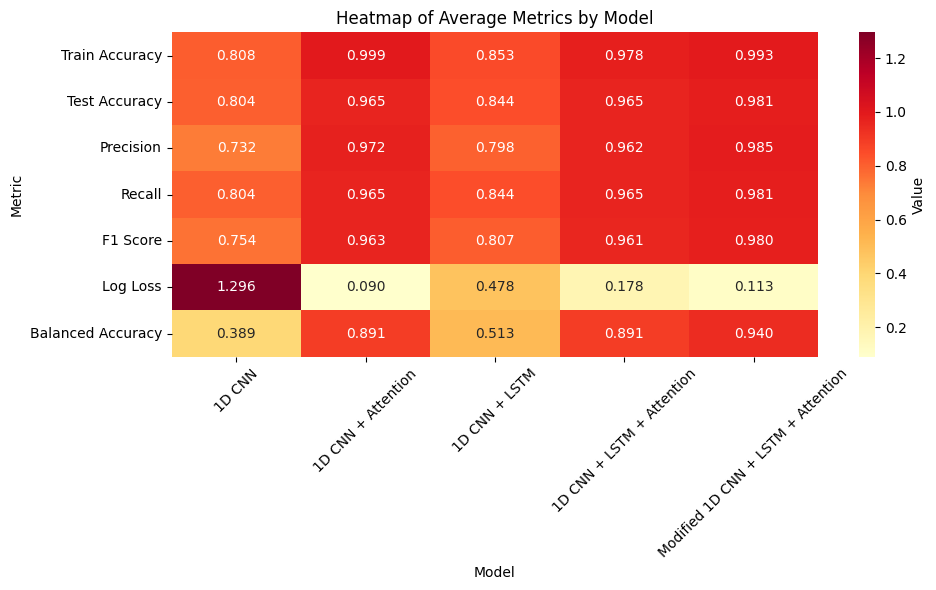

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metric_df.set_index('Model').T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Value'})
plt.title('Heatmap of Average Metrics by Model')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd

# Define the updated data
data = {
    'Model': [
        '1D CNN',
        '1D CNN + Attention',
        '1D CNN + LSTM',
        '1D CNN + LSTM + Attention',
        'Modified 1D CNN + LSTM + Attention'
    ],
    'Train Accuracy': [
        [0.793, 0.758, 0.847, 0.894, 0.748],
        [0.998, 1.0, 0.999, 0.997, 1.0],
        [0.856, 0.867, 0.839, 0.873, 0.831],
        [0.946, 0.986, 0.995, 0.986, 0.979],
        [0.993, 0.994, 0.999, 0.986, 0.992]
    ],
    'Test Accuracy': [
        [0.786, 0.754, 0.832, 0.904, 0.743],
        [0.936, 0.979, 0.961, 0.957, 0.993],
        [0.85, 0.868, 0.818, 0.854, 0.829],
        [0.914, 0.982, 0.964, 0.979, 0.986],
        [0.982, 0.989, 0.982, 0.982, 0.968]
    ],
    'Precision': [
        [0.763, 0.593, 0.82, 0.911, 0.574],
        [0.945, 0.985, 0.975, 0.962, 0.994],
        [0.811, 0.812, 0.776, 0.835, 0.758],
        [0.892, 0.984, 0.968, 0.981, 0.987],
        [0.986, 0.992, 0.985, 0.987, 0.975]
    ],
    'Recall': [
        [0.786, 0.754, 0.832, 0.904, 0.743],
        [0.936, 0.979, 0.961, 0.957, 0.993],
        [0.85, 0.868, 0.818, 0.854, 0.829],
        [0.914, 0.982, 0.964, 0.979, 0.986],
        [0.982, 0.989, 0.982, 0.982, 0.968]
    ],
    'F1 Score': [
        [0.756, 0.662, 0.815, 0.891, 0.648],
        [0.934, 0.977, 0.953, 0.956, 0.993],
        [0.812, 0.83, 0.79, 0.825, 0.777],
        [0.897, 0.982, 0.963, 0.978, 0.985],
        [0.982, 0.989, 0.982, 0.981, 0.966]
    ],
    'Log Loss': [
        [0.742, 2.105, 0.991, 0.586, 2.054],
        [0.18, 0.063, 0.097, 0.081, 0.03],
        [0.441, 0.433, 0.467, 0.444, 0.607],
        [0.25, 0.17, 0.172, 0.137, 0.163],
        [0.112, 0.098, 0.062, 0.108, 0.184]
    ],
    'Balanced Accuracy': [
        [0.333, 0.233, 0.478, 0.7, 0.2],
        [0.8, 0.933, 0.878, 0.867, 0.978],
        [0.533, 0.589, 0.433, 0.544, 0.467],
        [0.733, 0.944, 0.889, 0.933, 0.956],
        [0.944, 0.967, 0.944, 0.944, 0.9]
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV (optional)
df.to_csv('latest_training_metrics.csv', index=False)
print("Metrics DataFrame created and saved as 'latest_training_metrics.csv'.")

Metrics DataFrame created and saved as 'latest_training_metrics.csv'.


In [24]:
df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Log Loss,Balanced Accuracy
0,1D CNN,"[0.793, 0.758, 0.847, 0.894, 0.748]","[0.786, 0.754, 0.832, 0.904, 0.743]","[0.763, 0.593, 0.82, 0.911, 0.574]","[0.786, 0.754, 0.832, 0.904, 0.743]","[0.756, 0.662, 0.815, 0.891, 0.648]","[0.742, 2.105, 0.991, 0.586, 2.054]","[0.333, 0.233, 0.478, 0.7, 0.2]"
1,1D CNN + Attention,"[0.998, 1.0, 0.999, 0.997, 1.0]","[0.936, 0.979, 0.961, 0.957, 0.993]","[0.945, 0.985, 0.975, 0.962, 0.994]","[0.936, 0.979, 0.961, 0.957, 0.993]","[0.934, 0.977, 0.953, 0.956, 0.993]","[0.18, 0.063, 0.097, 0.081, 0.03]","[0.8, 0.933, 0.878, 0.867, 0.978]"
2,1D CNN + LSTM,"[0.856, 0.867, 0.839, 0.873, 0.831]","[0.85, 0.868, 0.818, 0.854, 0.829]","[0.811, 0.812, 0.776, 0.835, 0.758]","[0.85, 0.868, 0.818, 0.854, 0.829]","[0.812, 0.83, 0.79, 0.825, 0.777]","[0.441, 0.433, 0.467, 0.444, 0.607]","[0.533, 0.589, 0.433, 0.544, 0.467]"
3,1D CNN + LSTM + Attention,"[0.946, 0.986, 0.995, 0.986, 0.979]","[0.914, 0.982, 0.964, 0.979, 0.986]","[0.892, 0.984, 0.968, 0.981, 0.987]","[0.914, 0.982, 0.964, 0.979, 0.986]","[0.897, 0.982, 0.963, 0.978, 0.985]","[0.25, 0.17, 0.172, 0.137, 0.163]","[0.733, 0.944, 0.889, 0.933, 0.956]"
4,Modified 1D CNN + LSTM + Attention,"[0.993, 0.994, 0.999, 0.986, 0.992]","[0.982, 0.989, 0.982, 0.982, 0.968]","[0.986, 0.992, 0.985, 0.987, 0.975]","[0.982, 0.989, 0.982, 0.982, 0.968]","[0.982, 0.989, 0.982, 0.981, 0.966]","[0.112, 0.098, 0.062, 0.108, 0.184]","[0.944, 0.967, 0.944, 0.944, 0.9]"
